# Datasets Generation

In [12]:
import csv
import os

from random import uniform as unif

import networkx as nx

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
out_folder = "./datasets/set1"

In [7]:
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

## Characteristic

In [8]:
I = 50 # lvl1
J = 10 # lvl2
K = 10 # lvl3

## Geographic data

In [26]:
xy_lvl1 = [(unif(20,100),unif(20,70)) for i in range(I)]
xy_lvl2 = [(unif(20,100),unif(20,70)) for j in range(J)]
xy_lvl3 = [(unif(20,100),unif(20,70)) for k in range(K)]

In [79]:
G = nx.Graph()
for i,xy in enumerate(xy_lvl1):
    G.add_node(i,pos=xy,color="r",size=10)

In [80]:
pos    = nx.get_node_attributes(G,'pos')
colors = list(nx.get_node_attributes(G,'color').values())
size   = list(nx.get_node_attributes(G,'size').values())

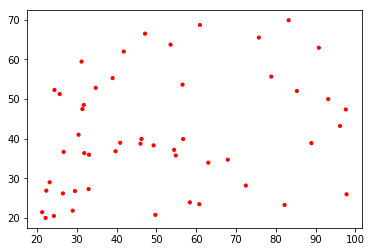

In [81]:
nx.draw_networkx(G,pos,node_color=colors,node_size=size,with_labels=False)